In [1]:
import pandas as pd
import numpy as np
import mysql.connector
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Conv1D
from tensorflow.keras.layers import Bidirectional, MultiHeadAttention, LayerNormalization, Add
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import joblib
from datetime import datetime

from dotenv import load_dotenv
import os
import mysql.connector

load_dotenv()


True

In [2]:
def load_hourly_sequences_for_next_hour(seq_hours=24, target_pollutants=['no2','pm10','o3','pm25'], lags=[1,2,3,24,48], verbose=True):
    print("🔌 Connexion à la base MySQL…")
    conn_mysql = mysql.connector.connect(
    host=os.getenv("DB_HOST"),
    user=os.getenv("DB_USER"),
    password=os.getenv("DB_PASSWORD"),
    database=os.getenv("DB_NAME")
)

    query = f"""
    SELECT pm.sensor_id, s.parameter, pm.datetime_utc, pm.value AS pollution_value,
           s.station_id, w.temperature_2m, w.humidity, w.precipitation, w.cloudcover, w.windspeed,
           w.pressure_msl, w.winddirection_10m, w.shortwave_radiation
    FROM pollution_measurements pm
    JOIN sensors s ON pm.sensor_id = s.sensor_id
    JOIN weather_measurements w ON s.station_id = w.station_id AND pm.datetime_utc = w.datetime_utc
    WHERE s.parameter IN ({','.join([f"'{p}'" for p in target_pollutants])})
    ORDER BY pm.sensor_id, pm.datetime_utc
    """
    df = pd.read_sql(query, conn_mysql, parse_dates=['datetime_utc'])
    conn_mysql.close()
    print(f"✅ Données chargées : {df.shape[0]} lignes")

    df['datetime_utc'] = df['datetime_utc'].dt.floor('h')

    df_hourly = df.groupby(['datetime_utc','parameter'], as_index=False)['pollution_value'].mean() \
                  .pivot(index='datetime_utc', columns='parameter', values='pollution_value')
    df_hourly = df_hourly.reindex(columns=target_pollutants)

    # Moyenne météo par heure avec nouvelles colonnes
    weather_cols = ['temperature_2m','humidity','precipitation','cloudcover','windspeed',
                    'pressure_msl','winddirection_10m','shortwave_radiation']
    df_weather = df.groupby('datetime_utc', as_index=False)[weather_cols].mean().set_index('datetime_utc')
    df_hourly = df_hourly.join(df_weather, how='left')

    df_hourly = df_hourly.interpolate(method='time', limit_direction='both')
    df_hourly = df_hourly.fillna(df_hourly.mean())
    print(f"✅ Interpolation et remplissage NaN : {df_hourly.isna().sum().sum()} restants")

    df_hourly['weekday'] = df_hourly.index.weekday
    df_hourly['month'] = df_hourly.index.month
    hours = df_hourly.index.hour
    df_hourly['hour_sin'] = np.sin(2 * np.pi * hours / 24)
    df_hourly['hour_cos'] = np.cos(2 * np.pi * hours / 24)

    for pol in target_pollutants:
        for lag in lags:
            df_hourly[f'{pol}_lag{lag}'] = df_hourly[pol].shift(lag).bfill()
        df_hourly[f'{pol}_delta'] = df_hourly[pol] - df_hourly[pol].shift(1).bfill()

    # Interactions avec les nouvelles colonnes météo
    for meteo in weather_cols:
        for pol in target_pollutants:
            df_hourly[f'{meteo}_x_{pol}'] = df_hourly[meteo] * df_hourly[pol]
    for time_feat in ['hour_sin', 'hour_cos']:
        for pol in target_pollutants:
            df_hourly[f'{time_feat}_x_{pol}'] = df_hourly[time_feat] * df_hourly[pol]
    for i, pol1 in enumerate(target_pollutants):
        for pol2 in target_pollutants[i+1:]:
            df_hourly[f'{pol1}_x_{pol2}'] = df_hourly[pol1] * df_hourly[pol2]

    df_hourly = df_hourly.sort_index()

    feature_cols = weather_cols + ['weekday','month','hour_sin','hour_cos']
    lag_cols = [col for col in df_hourly.columns if '_lag' in col or '_delta' in col]
    interaction_cols = [col for col in df_hourly.columns if '_x_' in col]
    feature_cols_all = feature_cols + lag_cols + interaction_cols

    feature_scaler = StandardScaler()
    df_hourly[feature_cols_all] = feature_scaler.fit_transform(df_hourly[feature_cols_all])

    target_scaler = MinMaxScaler()
    df_hourly[target_pollutants] = target_scaler.fit_transform(df_hourly[target_pollutants])

    X_list, y_list, meta_hours = [], [], []
    for i in range(seq_hours, len(df_hourly)):
        X_list.append(df_hourly.iloc[i-seq_hours:i][feature_cols_all + target_pollutants].values)
        y_list.append(df_hourly.iloc[i][target_pollutants].values)
        meta_hours.append(df_hourly.index[i])

    X = np.array(X_list, dtype=np.float32)
    y = np.array(y_list, dtype=np.float32)
    meta_hours = np.array(meta_hours)
    print(f"✅ Séquences créées : X={X.shape}, y={y.shape}")

    return X, y, feature_scaler, target_scaler, feature_cols_all + target_pollutants, meta_hours, df_hourly


In [3]:
def build_model(seq_hours, n_features, n_outputs, df_hourly, target_pollutants):
    variances = df_hourly[target_pollutants].var().values
    weights = variances.max() / variances
    pm10_idx = target_pollutants.index('pm10')
    weights[pm10_idx] *= 1.5  # pondération plus forte pour PM10
    weights_tf = tf.constant(weights, dtype=tf.float32)

    inputs = Input(shape=(seq_hours, n_features))
    x = Conv1D(64, 3, activation='relu', padding='causal')(inputs)
    x = Dropout(0.2)(x)
    x = Conv1D(64, 3, activation='relu', padding='causal')(x)
    x = Dropout(0.2)(x)
    x = Bidirectional(LSTM(128, return_sequences=True))(x)
    x = Dropout(0.2)(x)
    x = Bidirectional(LSTM(64, return_sequences=True))(x)
    x = Dropout(0.2)(x)
    attn_output = MultiHeadAttention(num_heads=4, key_dim=32)(x, x)
    x = Add()([x, attn_output])
    x = LayerNormalization()(x)
    x = Dense(64, activation='relu')(x)
    outputs = Dense(n_outputs, activation='linear')(x[:, -1, :])

    model = Model(inputs=inputs, outputs=outputs)

    def weighted_mixed_loss(y_true, y_pred):
        mse = tf.square(y_true - y_pred)
        mae = tf.abs(y_true - y_pred)
        weighted_loss = (mse + mae) * weights_tf
        return tf.reduce_mean(weighted_loss, axis=-1)
    
    
    
    

    model.compile(optimizer=tf.keras.optimizers.Adam(3e-4),
                  loss=weighted_mixed_loss,
                  metrics=['mae'])
    return model



In [4]:
seq_hours = 72
target_pollutants = ['no2','pm10','o3','pm25']

X, y, feature_scaler, target_scaler, feature_cols, meta_hours, df_hourly = load_hourly_sequences_for_next_hour(
    seq_hours=seq_hours, target_pollutants=target_pollutants
)

n = X.shape[0]
i_train = int(n*0.7)
i_val   = int(n*0.85)

X_train, y_train = X[:i_train], y[:i_train]
X_val, y_val     = X[i_train:i_val], y[i_train:i_val]
X_test, y_test   = X[i_val:], y[i_val:]
dates_test       = meta_hours[i_val:]

🔌 Connexion à la base MySQL…


C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_6272\1249419198.py:20: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn_mysql, parse_dates=['datetime_utc'])


✅ Données chargées : 544085 lignes
✅ Interpolation et remplissage NaN : 0 restants
✅ Séquences créées : X=(14061, 72, 86), y=(14061, 4)


In [5]:
# -----------------------
# Sauvegarde de la dernière séquence pour prédiction future
# -----------------------
np.save("model/last_sequence.npy", X_test[-1])
print("💾 Dernière séquence sauvegardée dans 'model/last_sequence.npy'")


💾 Dernière séquence sauvegardée dans 'model/last_sequence.npy'


In [6]:
print("📅 Dernières dates de test :")
print(dates_test[-10:])

print("\n⚡ Valeurs cibles correspondantes :")
print(y_test[-10:])

print("\n🧩 Features en entrée (dernières séquences) :")
# Affiche les 10 dernières séquences d'entrée (X_test) et leurs features
for i in range(-10, 0):
    print(f"\nSéquence {i + len(X_test)} :")
    print(X_test[i])


📅 Dernières dates de test :
[Timestamp('2025-08-15 14:00:00') Timestamp('2025-08-15 15:00:00')
 Timestamp('2025-08-15 16:00:00') Timestamp('2025-08-15 17:00:00')
 Timestamp('2025-08-15 18:00:00') Timestamp('2025-08-15 20:00:00')
 Timestamp('2025-08-15 21:00:00') Timestamp('2025-08-15 22:00:00')
 Timestamp('2025-08-15 23:00:00') Timestamp('2025-08-16 00:00:00')]

⚡ Valeurs cibles correspondantes :
[[0.05584025 0.0519597  0.4701893  0.05873314]
 [0.05850482 0.05835166 0.47589487 0.05109905]
 [0.06074461 0.0347226  0.46846685 0.05718378]
 [0.0915224  0.04138721 0.49688706 0.07695916]
 [0.10924762 0.07616434 0.5214318  0.1340035 ]
 [0.20621502 0.1088815  0.48945904 0.17608954]
 [0.24232197 0.1059733  0.42626715 0.15200415]
 [0.2190745  0.10638732 0.37846956 0.11777755]
 [0.15185602 0.12269541 0.36754283 0.09419923]
 [0.08463753 0.09598649 0.35661614 0.08253682]]

🧩 Features en entrée (dernières séquences) :

Séquence 2100 :
[[ 1.2056127  -1.2646365  -0.2575584  ...  0.1342575   0.44704404


In [7]:


print(f"Découpage train/val/test : {X_train.shape[0]}/{X_val.shape[0]}/{X_test.shape[0]} séquences")

n_features = X.shape[2]
n_outputs  = len(target_pollutants)
model = build_model(seq_hours, n_features, n_outputs, df_hourly, target_pollutants)
model.summary()

early_stop = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-5)


Découpage train/val/test : 9842/2109/2110 séquences
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 72, 86)]     0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 72, 64)       16576       ['input_1[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 72, 64)       0           ['conv1d[0][0]']                 
                                                                                                  
 conv1d_1 (Conv1D)              (None, 72, 64)       12352       ['dropout[0][0]']                
                                          

In [8]:

history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stop, lr_scheduler],
    verbose=1
)

y_pred_test = model.predict(X_test, verbose=1)
y_test_den  = target_scaler.inverse_transform(y_test)
y_pred_den  = target_scaler.inverse_transform(y_pred_test)


Epoch 1/50
308/308 [==============================] - 16s 35ms/step - loss: 0.3722 - mae: 0.1101 - val_loss: 0.1827 - val_mae: 0.0731 - lr: 3.0000e-04
Epoch 2/50
308/308 [==============================] - 9s 30ms/step - loss: 0.1578 - mae: 0.0626 - val_loss: 0.1444 - val_mae: 0.0603 - lr: 3.0000e-04
Epoch 3/50
308/308 [==============================] - 10s 31ms/step - loss: 0.1321 - mae: 0.0539 - val_loss: 0.1399 - val_mae: 0.0591 - lr: 3.0000e-04
Epoch 4/50
308/308 [==============================] - 10s 32ms/step - loss: 0.1161 - mae: 0.0473 - val_loss: 0.1140 - val_mae: 0.0478 - lr: 3.0000e-04
Epoch 5/50
308/308 [==============================] - 9s 30ms/step - loss: 0.1044 - mae: 0.0420 - val_loss: 0.1054 - val_mae: 0.0413 - lr: 3.0000e-04
Epoch 6/50
308/308 [==============================] - 8s 27ms/step - loss: 0.0965 - mae: 0.0383 - val_loss: 0.0922 - val_mae: 0.0364 - lr: 3.0000e-04
Epoch 7/50
308/308 [==============================] - 8s 27ms/step - loss: 0.0917 - mae: 0.0358 -

In [9]:

print("\n--- Évaluation Test ---")
for i, pol in enumerate(target_pollutants):
    mae  = np.mean(np.abs(y_test_den[:,i] - y_pred_den[:,i]))
    rmse = np.sqrt(np.mean((y_test_den[:,i] - y_pred_den[:,i])**2))
    r2   = 1 - np.sum((y_test_den[:,i]-y_pred_den[:,i])**2)/np.sum((y_test_den[:,i]-y_test_den[:,i].mean())**2)
    print(f"{pol}: MAE={mae:.2f}, RMSE={rmse:.2f}, R²={r2:.2f}")


--- Évaluation Test ---
no2: MAE=3.04, RMSE=4.48, R²=0.83
pm10: MAE=2.74, RMSE=3.99, R²=0.73
o3: MAE=8.34, RMSE=11.42, R²=0.82
pm25: MAE=1.40, RMSE=2.14, R²=0.74


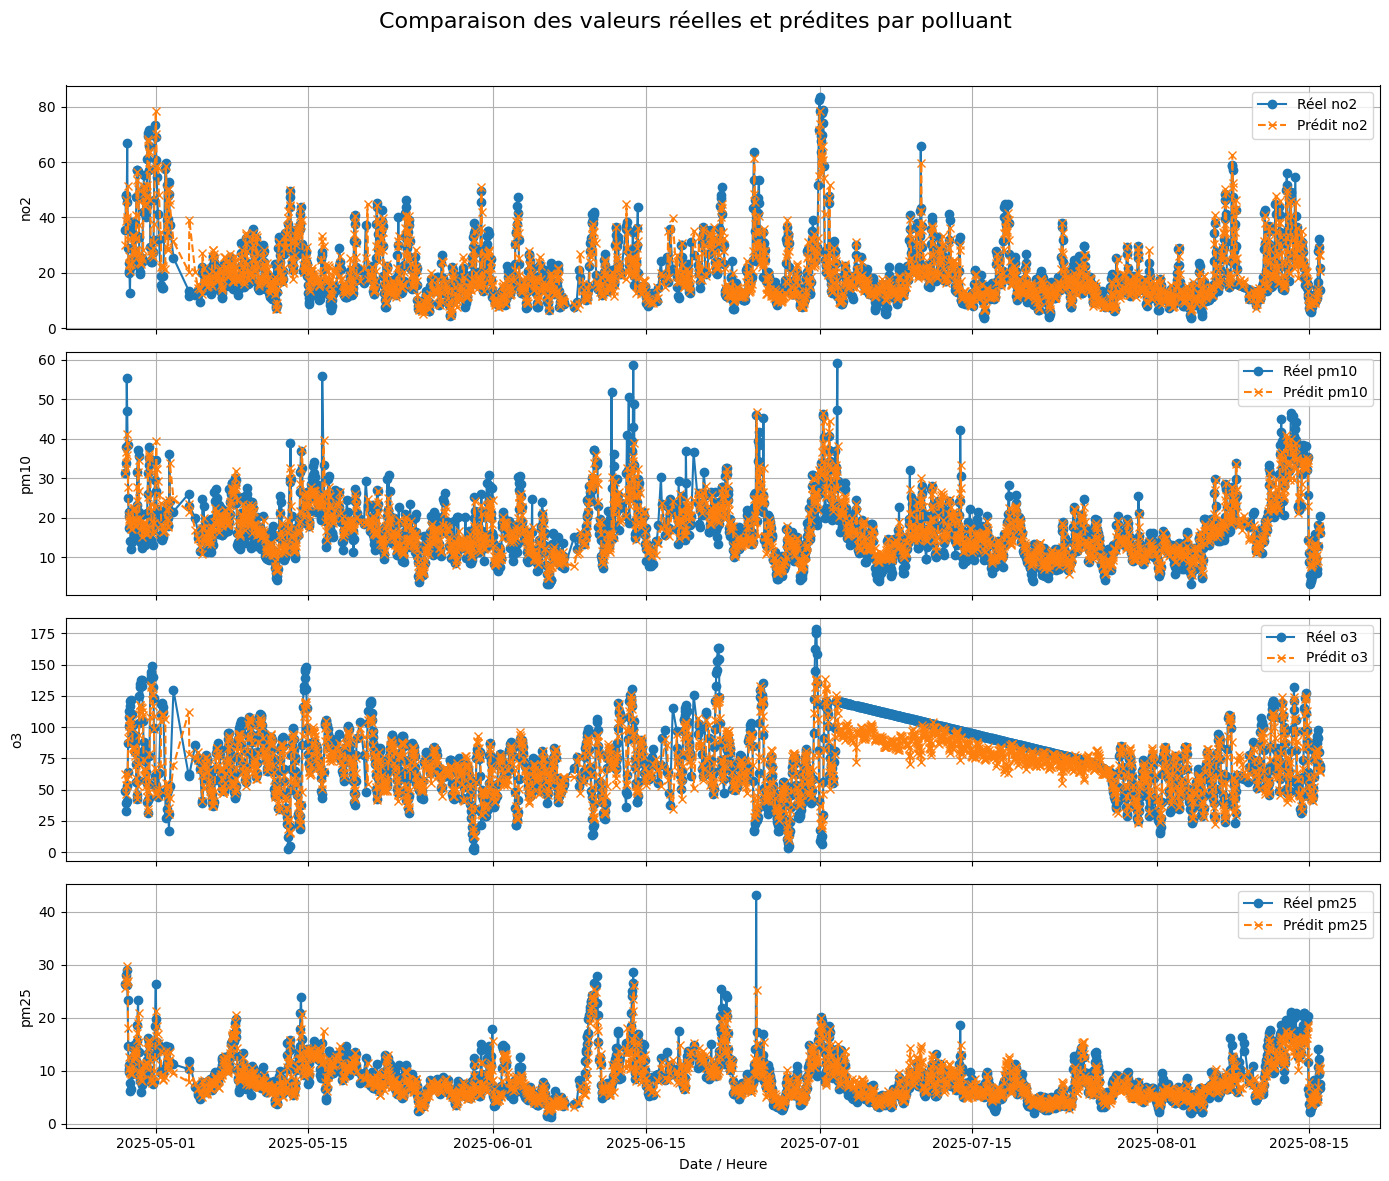

✅ Graphique sauvegardé : results\predictions_comparatives.png


In [10]:

# Graphiques comparatifs
os.makedirs("results", exist_ok=True)
fig, axes = plt.subplots(len(target_pollutants), 1, figsize=(14, 3*len(target_pollutants)), sharex=True)
for i, pol in enumerate(target_pollutants):
    axes[i].plot(dates_test, y_test_den[:, i], label=f"Réel {pol}", marker='o', linestyle='-')
    axes[i].plot(dates_test, y_pred_den[:, i], label=f"Prédit {pol}", marker='x', linestyle='--')
    axes[i].set_ylabel(pol)
    axes[i].legend()
    axes[i].grid(True)
axes[-1].set_xlabel("Date / Heure")
plt.suptitle("Comparaison des valeurs réelles et prédites par polluant", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plot_path = os.path.join("results", "predictions_comparatives.png")
plt.savefig(plot_path, dpi=300)
plt.show()
print(f"✅ Graphique sauvegardé : {plot_path}")

In [11]:
# Sauvegarde du modèle et des scalers
os.makedirs("model", exist_ok=True)
model_path = os.path.join("model", "pollution_model")
model.save(model_path)
joblib.dump(feature_scaler, os.path.join("model", "feature_scaler.pkl"))
joblib.dump(target_scaler, os.path.join("model", "target_scaler.pkl"))
print(f"💾 Modèle et scalers sauvegardés dans le dossier 'model'")


INFO:tensorflow:Assets written to: model\pollution_model\assets


INFO:tensorflow:Assets written to: model\pollution_model\assets


💾 Modèle et scalers sauvegardés dans le dossier 'model'
